# Predicción de series temporales con Python, Machine Learning y Scikit-learn

<a class="anchor" id="tc"></a>
## Tabla de contenidos

1. [Introducción](#1)
2. [Entrenamiento de un modelo de forecasting](#2)
3. [Predicciones multi-step](#3)
4. [Librerías para forecast](#4)
5. [Datos](#5)
6. [Forecasting autorregresivo recursivo](#6)
7. [Forecasting con variables exógenas](#7)
8. [Predictores custom y window features](#8)
9. [Direct multi-step forecasting](#9)
10. [Intervalos de predicción](#10)
11. [Métrica custom](#11)
12. [Guardar y cargar modelos](#12)
13. [Uso de modelos en producción](#13)
14. [Referencias](#14)


## **1. Introducción** <a class="anchor" id="1"></a>

[Tabla de contenidos](#tc)

Una serie temporal (time series) es una sucesión de datos ordenados cronológicamente, espaciados a intervalos iguales o desiguales. El proceso de forecasting consiste en predecir el valor futuro de una serie temporal, bien modelando la serie únicamente en función de su comportamiento pasado (autorregresivo) o empleando otras variables externas.

Esta guía describe cómo utilizar modelos de regresión de Scikit-learn para realizar forecasting de series temporales. En concreto, se hace uso de Skforecast, una librería que contiene las clases y funciones necesarias para adaptar cualquier modelo de regresión de Scikit-learn a problemas de forecasting.

## **2. Entrenamiento de un modelo de forecasting** <a class="anchor" id="2"></a>

[Tabla de contenidos](#tc)

La principal adaptación que se necesita hacer para aplicar modelos de machine learning a problemas de forecasting es transformar la serie temporal en un matriz en la que, cada valor, está asociado a la ventana temporal (lags) que le precede.

![image.png](../../figures/transform_timeseries.gif)

*Transformación de una serie temporal en una matriz de 5 lags y un vector con el valor de la serie que sigue a cada fila de la matriz.*

Este tipo de transformación también permite incluir variables exógenas a la serie temporal.

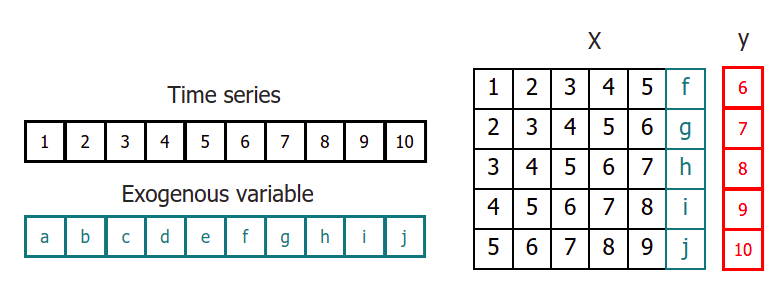

*Transformación de una serie temporal junto con una variable exógena.*

Una vez que los datos se encuentran reordenados de esta forma, se puede entrenar cualquier modelo de regresión para que aprenda a predecir el siguiente valor de la serie.

## **3. Predicciones multi-step** <a class="anchor" id="3"></a>

[Tabla de contenidos](#tc)

Cuando se trabaja con series temporales, raramente se quiere predecir solo el siguiente elemento de la serie (t+1), sino todo un intervalo futuro o un punto alejado en el tiempo (t+n). A cada paso de predicción se le conoce como step. 

Existen varias estrategias que permiten generar este tipo de predicciones múltiples.

### Recursive multi-step forecasting
Dado que, para predecir el momento  tn  se necesita el valor de  tn−1, y  tn−1 se desconoce, se sigue un proceso recursivo en el que, cada nueva predicción, hace uso de la predicción anterior. 
- A este proceso se le conoce como recursive forecasting o recursive multi-step forecasting y pueden generarse fácilmente con la clase `ForecasterRecursive` de la librería **skforecast**.

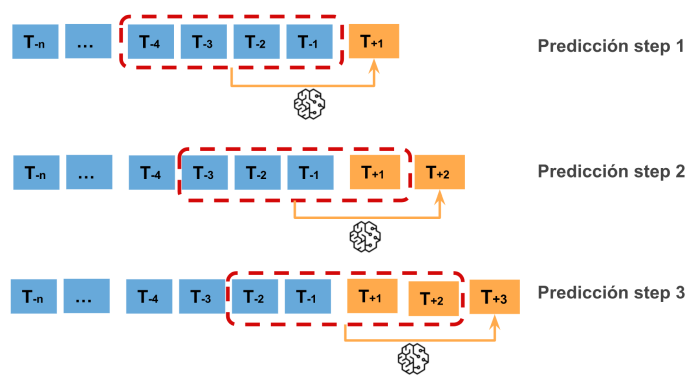

*Diagrama del proceso de predicción multi-step recursivo para predecir 3 steps a futuro utilizando los últimos 4 lags de la serie como predictores.*

![image.png](../../figures/recursive_forecasting_gif.gif)


### Direct multi-step forecasting
El método direct multi-step forecasting consiste en entrenar un modelo distinto para cada step. Por ejemplo, si se quieren predecir los siguientes 5 valores de una serie temporal, se entrenan 5 modelos distintos, uno para cada step. Como resultado, las predicciones son independientes unas de otras.

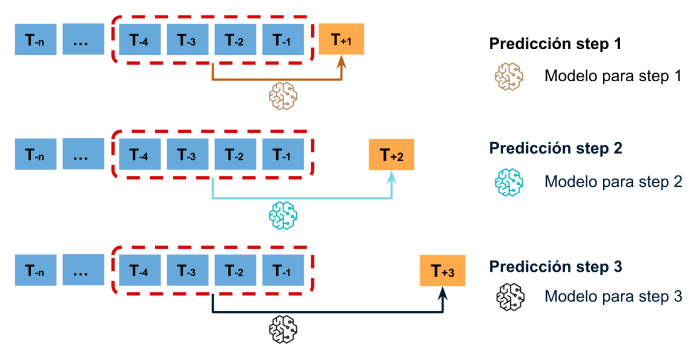

*Diagrama del proceso de predicción multi-step directo, para predecir 3 steps a futuro utilizando los últimos 4 lags de la serie como predictores.*

![image.png](../../figures/direct_forecasting.gif)

La principal complejidad de esta aproximación consiste en generar correctamente las matrices de entrenamiento para cada modelo. Todo este proceso está automatizado en la clase `ForecasterDirect` de la librería **skforecast**. También es importante tener en cuenta que esta estrategia tiene un coste computacional más elevado ya que requiere entrenar múltiples modelos. En el siguiente esquema se muestra el proceso para un caso en el que se dispone de la variable respuesta y dos variables exógenas.

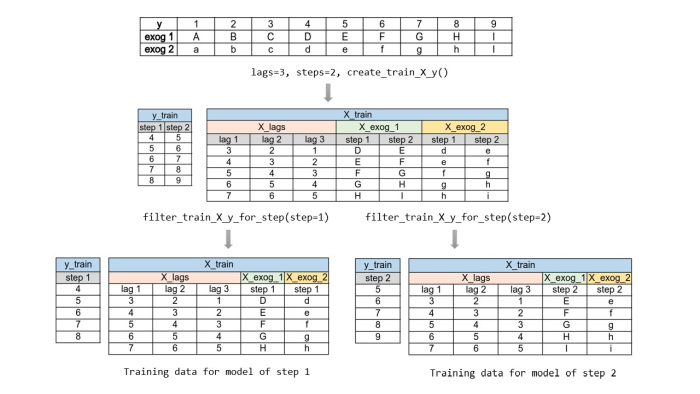

### Forecasting multi-output

Determinados modelos, por ejemplo, las redes neuronales LSTM, son capaces de predecir de forma simultánea varios valores de una secuencia (one-shot). Esta estrategia está disponible con la clase `ForecasterRnn` de la librería **skforecast**.

## **4. Librerías para forecast** <a class="anchor" id="4"></a>

[Tabla de contenidos](#tc)

- **skforecast**:
    - datasets
    - recursive
    - direct
    - model_selection
    - model_selection
    - model_selection
    - preprocessing
    - utils

- **shap**: 

In [ ]:
# ! pip install skforecast
# ! pip install shap

In [ ]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================
import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import skforecast
from skforecast.recursive import ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.preprocessing import RollingFeatures
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
import shap


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

color = '\033[1m\033[38;5;208m' 
print(f"{color}Versión skforecast: {skforecast.__version__}")
print(f"{color}Versión scikit-learn: {sklearn.__version__}")
print(f"{color}Versión pandas: {pd.__version__}")
print(f"{color}Versión numpy: {np.__version__}")

## **5. Datos** <a class="anchor" id="5"></a>

[Tabla de contenidos](#tc)

Se dispone de una serie temporal con el gasto mensual (millones de dólares) en fármacos con corticoides que tuvo el sistema de salud Australiano entre 1991 y 2008. 

Se pretende crear un modelo autoregresivo capaz de predecir el futuro gasto mensual. 

Los datos empleados en los ejemplos de este documento se han obtenido del magnífico libro Forecasting: [Principles and Practice by Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp3/).

In [ ]:
# Descarga de datos
datos = fetch_dataset(name='h2o_exog', raw=True)

La columna 'fecha' se ha almacenado como 'string'. 

Para convertirla en `datetime`, se emplea la función `pd.to_datetime()`. 

Una vez en formato `datetime`, y para hacer uso de las funcionalidades de Pandas, se establece como índice. 

Además, dado que los datos son mensuales, se indica la frecuencia (Monthly Started 'MS').

In [ ]:
# Preparación del dato

datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()
datos.head()

Cuando se utiliza el método `asfreq()` en Pandas, cualquier hueco en la serie temporal se rellena con valores NaN para ajustarse a la frecuencia especificada. 

Por lo tanto, es importante comprobar cualquier valor NaN añadido tras esta transformación.

In [ ]:
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')

Aunque no es necesario al haber establecido un frecuencia, se puede verificar que la serie temporal esté completa.

In [ ]:
# Verificar que un índice temporal está completo

fecha_inicio = datos.index.min()
fecha_fin = datos.index.max()
date_range_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=datos.index.freq)
print(f"Índice completo: {(datos.index == date_range_completo).all()}")

In [ ]:
# Completar huecos en un índice temporal

# datos.asfreq(freq='30min', fill_value=np.nan)

Se utilizan los últimos 36 meses como conjunto de test para evaluar la capacidad predictiva del modelo.

In [ ]:
# Separación datos train-test

steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

## **6. Forecasting autorregresivo recursivo** <a class="anchor" id="6"></a>

[Tabla de contenidos](#tc)

### ForecasterRecursive

Se crea y entrena un modelo `ForecasterRecursive` a partir de un regresor `RandomForestRegressor` y una ventana temporal de 6 lags. 

Esto último significa que, el modelo, utiliza como predictores los 6 meses anteriores.

In [ ]:
# Crear y entrenar forecaster

forecaster = ForecasterRecursive(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )
forecaster.fit(y=datos_train['y'])
forecaster

### Predicciones
Una vez entrenado el modelo, se predicen los datos de test (36 meses a futuro).

In [ ]:
# Predicciones

steps = 36
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

In [ ]:
# Gráfico de predicciones vs valores reales

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

### Error de predicción en los datos de test

Se cuantifica el error que comete el modelo en sus predicciones. En este caso, se emplea como métrica el mean squared error (mse).

In [ ]:
# Error test

error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

### Ajuste de hiperparámetros (tuning)

- El `ForecasterRecursive` entrenado ha utilizado una ventana temporal de 6 lags y un modelo Random Forest con los hiperparámetros por defecto. 

- Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados. 

- La librería Skforecast proporciona varias estrategias de búsqueda para encontrar la mejor combinación de hiperparámetros y lags. 

- En este caso, se utiliza la función `grid_search_forecaster`, que compara los resultados obtenidos con cada combinación de hiperparámetros y lags, e identifica la mejor.

### *Tip*

El coste computacional del ajuste de hiperparámetros depende en gran medida del enfoque de backtesting elegido para evaluar cada combinación de hiperparámetros. 

- En general, la duración del proceso de ajuste aumenta a medida que crece el número de reentrenamientos implicados en el backtesting.

Para acelerar la fase de prototipado, es muy recomendable adoptar una estrategia en dos pasos. 

- En primer lugar, utilizar `refit=False` durante la búsqueda inicial para reducir el rango de valores. 

- A continuación, focalizarse en la región de interés identificada y aplicar una estrategia de backtesting que cumpla los requisitos específicos del caso de uso. 

- Para una documentación más detallada visitar: [Hyperparameter tuning and lags selection](https://skforecast.org/latest/user_guides/hyperparameter-tuning-and-lags-selection.html)

In [ ]:
# Búsqueda de hiperparámetros: grid search

forecaster = ForecasterRecursive(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Particiones de entrenamiento y validación
cv = TimeSeriesFold(
      steps              = 36,
      initial_train_size = int(len(datos_train) * 0.5),
      refit              = False,
      fixed_train_size   = False,

    )

# Valores candidatos de lags
lags_grid = [10, 20]

# Valores candidatos de hiperparámetros del regresor
param_grid = {
      'n_estimators': [100, 250],
      'max_depth': [3, 5, 10]
}

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos_train['y'],
                        cv          = cv,
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        metric      = 'mean_squared_error',  
                        return_best = True,
                        n_jobs      = 'auto',
                        verbose     = False
                  )

In [ ]:
# Resultados de la búsqueda de hiperparámetros

resultados_grid

### Modelo final
Finalmente, se entrena de nuevo un `ForecasterRecursive` con la mejor configuración encontrada. 

Este paso no es necesario si se indica `return_best = True` en la función `grid_search_forecaster`.

In [ ]:
# Crear y entrenar forecaster con mejores hiperparámetros

regressor = RandomForestRegressor(n_estimators=250, max_depth=3, random_state=123)
forecaster = ForecasterRecursive(
                regressor = regressor,
                lags      = 20
             )
forecaster.fit(y=datos_train['y'])

In [ ]:
# Predicciones

predicciones = forecaster.predict(steps=steps)

In [ ]:
# Gráfico de predicciones vs valores reales

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error de test

error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )
print(f"Error de test (mse) {error_mse}")

Con la combinación óptima de hiperparámetros se consigue reducir notablemente el error de test.

### Backtesting
Para obtener una estimación robusta de la capacidad predictiva del modelo, se lleva a cabo un proceso de backtesting. 

- El backtesting consiste en evaluar el comportamiento de un modelo predictivo al aplicarlo de forma retrospectiva sobre datos históricos. 

- Por lo tanto, es una estrategia de validación que permite cuantificar la capacidad predictiva de un modelo.

<br>

> **Nota:**
>
> Para garantizar una evaluación precisa de su modelo y ganar confianza en su rendimiento predictivo con nuevos datos, es fundamental emplear una estrategia de backtesting adecuada. 
> - Factores como las características del caso de uso, los recursos informáticos disponibles y los intervalos de tiempo entre predicciones deben tenerse en cuenta para determinar qué estrategia utilizar.
>
> En términos generales, cuanto más se parezca el proceso de backtesting al escenario real en el que se utilizará el modelo, más fiable será la métrica estimada. 
> - Para obtener más consejos sobre estrategias de backtesting, consultar Which strategy should I use?.

#### Backtesting con reentrenamiento

El modelo se entrena cada vez antes de realizar las predicciones, de esta forma, se incorpora toda la información disponible hasta el momento. 

Se trata de una adaptación del proceso de cross-validation en el que, en lugar de hacer un reparto aleatorio de las observaciones, el conjunto de entrenamiento se incrementa de manera secuencial, manteniendo el orden temporal de los datos.

![image.png](../../figures/backtesting_refit.gif)


*Diagrama de time series backtesting con un tamaño inicial de entrenamiento de 10 observaciones, un horizonte de predicción de 3 steps y reentrenamiento en cada iteración.*

#### Backtesting con reentrenamiento y tamaño de entrenamiento constante

Similar a la estrategia anterior, pero, en este caso, el tamaño del conjunto de entrenamiento no se incrementa sino que la ventana de tiempo que abarca se desplaza. 

Esta estrategia se conoce también como time series cross-validation o walk-forward validation.

![image.png](../../figures/backtesting_refit_fixed_train_size.gif)


*Diagrama de time series backtesting con un tamaño inicial de entrenamiento de 10 observaciones, un horizonte de predicción de 3 steps y set de entrenamiento con tamaño constante.*

#### Backtesting con reentrenamiento cada n periodos (intermitente)

El modelo se reentrena de forma intermitente cada  n
  periodos de predicción.

> **Tip**: Esta estrategia suele lograr un buen equilibrio entre el coste computacional del reentrenamiento y evitar la degradación del modelo.


![image.png](../../figures/backtesting_intermittent_refit.gif)


*Diagrama de time series backtesting con un tamaño inicial de entrenamiento de 10 observaciones, un horizonte de predicción de 3 steps y una frecuencia de reentrenamiento intermitente.*

#### Backtesting sin reentrenamiento

Con esta estrategia, el modelo se entrena una única vez con un conjunto inicial y se realizan las predicciones de forma secuencial sin actualizar el modelo y siguiendo el orden temporal de los datos. 

Esta estrategia tiene la ventaja de ser mucho más rápida puesto que el modelo solo se entrena una vez. 

La desventaja es que el modelo no incorpora la última información disponible por lo que puede perder capacidad predictiva con el tiempo.

![image.png](../../figures/backtesting_no_refit.gif)


*Diagrama de time series backtesting con un tamaño inicial de entrenamiento de 10 observaciones, un horizonte de predicción de 3 steps, sin reentrenamiento en cada iteración.*

### *Skip folds*

Todos las estrategias de backtesting mencionadas pueden combinarse con la opción de saltarse un cierto número de folds mediante el argumento `skip_folds`. 
- Dado que el modelo predice menos puntos en el tiempo, el coste computacional se reduce y el proceso de backtesting es más rápido. 
- Esto es particularmente útil cuando se busca una estimación aproximada del rendimiento del modelo, pero no se requiere una evaluación exacta, por ejemplo, al buscar hiperparámetros. 
- Si `skip_folds` es un entero, se devolverá cada 'skip_folds'-ésimo. 
- Si `skip_folds` es una lista, se saltarán los folds de la lista. 
    - Por ejemplo, si `skip_folds = 3`, y hay 10 folds, los folds devueltos serán [0, 3, 6, 9]. 
- Si `skip_folds` es una lista [1, 2, 3], los folds devueltos serán [0, 4, 5, 6, 7, 8, 9].

La librería **skforecast** dispone de múltiples [estrategias de backtesting](https://skforecast.org/latest/user_guides/backtesting.html) mencionadas. Independientemente de cuál se utilice, es importante no incluir los datos de test en el proceso de búsqueda para no caer en problemas de overfitting.

Para este ejemplo, se sigue una estrategia de **backtesting con reentrenamiento**. Internamente, el proceso seguido por la función es el siguiente:

- En la primera iteración, el modelo se entrena con las observaciones seleccionadas para el entrenamiento inicial (en este caso, 87). 
    - Después, se predicen las siguientes 36 observaciones.
- En la segunda iteración, se reentrena el modelo extendiendo el conjunto de entrenamiento inicial con 36 observaciones (87 + 36), y se predicen las siguientes 36.
- Este proceso se repite hasta que se utilizan todas las observaciones disponibles y se calcula la métrica de validación con todas las predicciones acumuladas. 

Siguiendo esta estrategia, el conjunto de entrenamiento aumenta en cada iteración con tantas observaciones como steps se estén prediciendo.

In [ ]:
# Backtesting

cv = TimeSeriesFold(
         steps              = 12 * 3, 
         initial_train_size = len(datos) - 12 * 9,
         fixed_train_size   = False,
         refit              = True,
)

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = datos['y'],
                                    cv         = cv,
                                    metric     = 'mean_squared_error',
                                    verbose    = True
                                 )
metrica

In [ ]:
# Gráfico de predicciones de backtest vs valores reales

fig, ax = plt.subplots(figsize=(6, 2.5))
datos.loc[predicciones_backtest.index, 'y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend();

### Explicabilidad del modelo (importancia de los predictores)

Debido a la naturaleza compleja de muchos de los actuales modelos de machine learning, a menudo funcionan como cajas negras, lo que dificulta entender por qué han hecho una predicción u otra. 
- Las técnicas de explicabilidad pretenden desmitificar estos modelos, proporcionando información sobre su funcionamiento interno y ayudando a generar confianza, mejorar la transparencia y cumplir los requisitos normativos en diversos ámbitos. 
- Mejorar la explicabilidad de los modelos no sólo ayuda a comprender su comportamiento, sino también a identificar sesgos, mejorar su rendimiento y permitir a las partes interesadas tomar decisiones más informadas basadas en los conocimientos del machine learning.

Skforecast es compatible con algunos de los métodos de explicabilidad más populares: [model-specific feature importances, SHAP values, and partial dependence plots](https://skforecast.org/latest/user_guides/explainability.html).

#### Importancia model-specific

In [ ]:
# Importancia predictores

importancia = forecaster.get_feature_importances()
importancia.head(10)

> ⚠ Warning
>
> `get_feature_importances()` solo devuelve valores si el regresor utilizado dentro del forecaster tiene el atributo `coef_` o `feature_importances_`.

#### Shap values

Los valores SHAP (SHapley Additive exPlanations) son un método muy utilizado para explicar los modelos de machine learning, ya que ayudan a comprender cómo influyen las variables y los valores en las predicciones de forma visual y cuantitativa.

Se puede obtener un análisis SHAP a partir de modelos skforecast con sólo dos elementos:

- El regresor interno del forecaster.

- Las matrices de entrenamiento creadas a partir de la serie temporal y variables exógenas, utilizadas para ajustar el pronosticador.

Aprovechando estos dos componentes, los usuarios pueden crear explicaciones interpretables para sus modelos de skforecast. Estas explicaciones pueden utilizarse para verificar la fiabilidad del modelo, identificar los factores más significativos que contribuyen a las predicciones y comprender mejor la relación subyacente entre las variables de entrada y la variable objetivo.

In [ ]:
# Matrices de entrenamiento utilizadas por el forecaster para entrenar el regresor

X_train, y_train = forecaster.create_train_X_y(y=datos_train['y'])

# Crear SHAP explainer (para modelos basados en árboles)

explainer = shap.TreeExplainer(forecaster.regressor)
# Se selecciona una muestra del 50% de los datos para acelerar el cálculo
rng = np.random.default_rng(seed=785412)
sample = rng.choice(X_train.index, size=int(len(X_train)*0.5), replace=False)
X_train_sample = X_train.loc[sample, :]
shap_values = explainer.shap_values(X_train_sample)

# Shap summary plot (top 10)

shap.initjs()
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)
fig, ax = plt.gcf(), plt.gca()
ax.set_title("SHAP Summary plot")
ax.tick_params(labelsize=8)
fig.set_size_inches(6, 3.5)

## **7. Forecasting con variables exógenas** <a class="anchor" id="7"></a>

[Tabla de contenidos](#tc)

En el ejemplo anterior, se han utilizado como predictores únicamente lags de la propia variable predicha. 
- En ciertos escenarios, es posible disponer de información sobre otras variables, cuyo valor a futuro se conoce, y pueden servir como predictoreres adicionales en el modelo.

Siguiendo con el ejemplo anterior, se simula una nueva variable cuyo comportamiento está correlacionado con la serie temporal modelada y que, por lo tanto, se quiere incorporar como predictor. 
- Esto mísmo es aplicable a múltiples variables exógenas.


In [ ]:
# Descarga de datos

datos = fetch_dataset(name='h2o_exog', raw=True, verbose=False)

In [ ]:
# Preparación del dato

datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()

fig, ax = plt.subplots(figsize=(6, 2.5))
datos['y'].plot(ax=ax, label='y')
datos['exog_1'].plot(ax=ax, label='variable exógena')
ax.legend();

In [ ]:
# Separación datos train-test

steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]
print(
    f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})"
)
print(
    f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})"
)

In [ ]:
# Crear y entrenar forecaster

forecaster = ForecasterRecursive(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )
forecaster.fit(y=datos_train['y'], exog=datos_train['exog_1'])
forecaster

Si el `ForecasterRecursive` se entrena con una variable exógena, hay que pasarle el valor de esta variable al predict(). Por lo tanto, solo es aplicable a escenarios en los que se dispone de información a futuro de la variable exógena.

In [ ]:
# Predicciones

predicciones = forecaster.predict(steps=steps, exog=datos_test['exog_1'])

In [ ]:
# Gráfico predicciones vs valores reales

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error test

error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

## **8. Predictores custom y window features** <a class="anchor" id="8"></a>

[Tabla de contenidos](#tc)

En determinados escenarios, puede ser interesante incorporar otras características de la serie temporal además de los lags, por ejemplo, la media movil de los últimos n valores puede servir para capturar la tendencia de la serie. El argumento `window_features` permite incorporar al modelo predictores adicionales, creados a partir de los valores pasados de la serie temporal.

La clase `RollingFeatures` disponible en skforecast permite crear algunos de los predictores más utilizados:

- *'mean'*: la media de los n valores anteriores.
- *'std'*: la desviación estándar de los n valores anteriores.
- *'min'*: el mínimo de los n valores anteriores.
- *'max'*: el máximo de los n valores anteriores.
- *'sum'*: la suma de los n valores anteriores.
- *'median'*: la mediana de los n valores anteriores.
- *'ratio_min_max'*: la relación entre el mínimo y el máximo de los n valores anteriores.
- *'coef_variation'*: el coeficiente de variación de los n valores anteriores.
El usuario puede especificar un tamaño de ventana diferente para cada uno de ellos o el mismo para todos.

>⚠ Warning
>
>`RollingFeatures` es muy útil para incluir algunos de los predictores más utilizados. Sin embargo, es posible que se necesite incluir otros predictores que no estén disponibles en esta clase. En este caso, el usuario puede crear su propia clase para calcular los predictores deseadas e incluirlos en el forecaster. Para más información, consultar la documentación de window-features and custom features.

In [ ]:
# Descarga de datos

datos = fetch_dataset(name='h2o_exog', raw=True, verbose=False)

# Preparación del dato

datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()

# Separación datos train-test

steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Se crea y entrena un de nuevo un `ForecasterRecursive` a partir de un regresor `RandomForestRegressor` pero esta vez, además de los 10 lags, se incluyen como predictores la media móvil, valor máximo, valor mínimo y desviación típica de los últimos 20 valores.

In [ ]:
# Window features

window_features = RollingFeatures(
    stats = ['mean', 'std', 'min', 'max'],
    window_sizes = 20
)

In [ ]:
# Crear y entrenar forecaster

forecaster = ForecasterRecursive(
                regressor       = RandomForestRegressor(random_state=123),
                lags            = 10,
                window_features = window_features,
             )
forecaster.fit(y=datos_train['y'])
forecaster

Mediante el método `create_train_X_y`, se puede acceder a las matrices que se crean internamente en el proceso de entrenamiento del forecaster y que se utilizan para ajustar el modelo. 

Esto permite al usuario inspeccionar los datos y entender cómo se han creado los predictores.

In [ ]:
# Matrices de entrenamiento

X_train, y_train = forecaster.create_train_X_y(y=datos_train['y'])
display(X_train.head(5))
display(y_train.head(5))

In [ ]:
# Predicciones

steps = 36
predicciones = forecaster.predict(steps=steps)
# Gráfico predicciones vs valores reales

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error test

error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

## **9. Direct multi-step forecasting** <a class="anchor" id="9"></a>

[Tabla de contenidos](#tc)

Para conseguir predicciones de varios steps a futuro, los modelos `ForecasterRecursive` siguen una estrategia de predicción recursiva en la que, cada nueva predicción, se basa en la predicción anterior. 
- Una alternativa es entrenar un modelo para cada uno de los steps que se desea predecir. 
- Esta estrategia, normalmente conocida como direct multi-step forecasting, es computacionalmente más costosa que la recursiva puesto que requiere entrenar varios modelos. 
- Sin embargo, en algunos escenarios, consigue mejores resultados. 
- Este tipo de modelos pueden obtenerse con la clase `ForecasterDirect` y pueden incluir también window features y variables exógenas.

> ⚠ Warning
>
> Los `ForecasterDirect` pueden requerir tiempos de entrenamiento elevados, ya que se ajusta un modelo por cada step.

### ForecasterDirect
A diferencia de cuando se utiliza `ForecasterRecursive`, en los modelos de tipo `ForecasterDirect` hay que indicar, en el momento de su creación, el número de steps que se quieren predecir. 
- No es posible predecir steps más allá del valor definido en su creación.

Para este ejemplo, se utiliza como regresor un modelo lineal con penalización de [Ridge](https://www.cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python#Ridge). 
- Estos modelos requieren que los predictores se estandaricen, por lo que se combina con un `StandardScaler`. 
- Para una documentación más detallada de como incluir transformers y pipelines, visitar: [skforecast with transformers and pipeline](https://skforecast.org/latest/user_guides/sklearn-transformers-and-pipeline.html).

In [ ]:
# Crear forecaster

forecaster = ForecasterDirect(
                regressor     = Ridge(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8
             )
forecaster

In [ ]:
# Búsqueda de hiperparámetros

from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

forecaster = ForecasterDirect(
                regressor     = Ridge(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8 # Este valor será remplazado en el grid search
             )

cv = TimeSeriesFold(
         steps              = 36, 
         initial_train_size = int(len(datos_train) * 0.5),
         fixed_train_size   = False,
         refit              = False,
)

param_grid = {'alpha': np.logspace(-5, 5, 10)}

lags_grid = [5, 12, 20]

resultados_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = datos_train['y'],
                    cv                 = cv,
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    metric             = 'mean_squared_error',
                    return_best        = True,
                    n_jobs             = 'auto',
                    verbose            = False
                )

In [ ]:
# Resultados de la búsqueda de hiperparámetros
resultados_grid.head()

Los mejores resultados se obtienen utilizando una ventana temporal de 12 lags y una configuración de Lasso {'alpha': 0.2782559}.

In [ ]:
# Predicciones

predicciones = forecaster.predict()

# Gráfico predicciones vs valores reales

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error test

error_mse = mean_squared_error(y_true = datos_test['y'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

## **10. Intervalos de predicción** <a class="anchor" id="10"></a>

[Tabla de contenidos](#tc)

Un intervalo de predicción define el espacio dentro del cual es de esperar que se encuentre el verdadero valor de  *y* con una determinada probabilidad. Por ejemplo, es de esperar que el intervalo de predicción (1, 99) contenga el verdadero valor de la predicción con un 98% de probabilidad.

Rob J Hyndman y George Athanasopoulos, listan en su libro *Forecasting: Principles and Practice* [mútiples formas de estimar intervalos de predicción](https://otexts.com/fpp3/prediction-intervals.html), la mayoría de los cuales requieren que los residuos (errores) del modelo se distribuyan de forma normal. 

Cuando no se puede asumir esta propiedad, se puede recurrir a bootstrapping, que solo asume que los residuos no están correlacionados. Este es el método utilizado en la librería Skforecast. Puede encontrarse más detalle en [skforecast probabilistic forecasting](https://skforecast.org/latest/user_guides/probabilistic-forecasting.html).

![image.png](../../figures/bootstrapped-prediction-interval.gif)


*Diagrama de cómo crear intervalos de predicción utilizando el proceso de bootstrapping.*

In [ ]:
# Descarga de datos
# ==============================================================================
datos = fetch_dataset(name='h2o_exog', raw=True, verbose=False)

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()

# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                    regressor = Ridge(alpha=0.1, random_state=765),
                    lags = 15
             )
forecaster.fit(y=datos_train['y'])

# Intervalos de predicción
# ==============================================================================
predicciones = forecaster.predict_interval(
                    steps    = steps,
                    interval = [1, 99],
                    n_boot   = 500
               )
predicciones.head(5)

In [ ]:
# Error de predicción
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones['pred']
            )
print(f"Error de test (mse): {error_mse}")

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_test['y'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend(loc='upper left');

In [ ]:
# Backtest con intervalos de predicción
# ==============================================================================
forecaster = ForecasterRecursive(
                regressor = Ridge(alpha=0.1, random_state=765),
                lags      = 15
             )
cv = TimeSeriesFold(
         steps              = 36, 
         initial_train_size = len(datos) - 12 * 9,
         fixed_train_size   = False,
         refit              = True,
)
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos['y'],
                            cv                 = cv,
                            metric             = 'mean_squared_error',
                            interval           = [1, 99],
                            n_boot             = 100,
                            n_jobs             = 'auto',
                            verbose            = True
                       )
display(metrica)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos.loc[predicciones.index, 'y'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

In [ ]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                     (datos.loc[predicciones.index, 'y'] >= predicciones['lower_bound']) & \
                     (datos.loc[predicciones.index, 'y'] <= predicciones['upper_bound']),
                     True,
                     False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {round(100*cobertura, 2)} %")

## **11. Métrica custom** <a class="anchor" id="11"></a>

[Tabla de contenidos](#tc)

En los procesos de backtesting (`backtesting_forecaster`) y optimización de hiperparámetros (`grid_search_forecaster`), además de las métricas *mean_squared_error, mean_absolute_error y mean_absolute_percentage_error*, el usuario puede utilizar cualquier función que desee siempre y cuando cumpla lo siguiente:

- Tiene como argumentos:
    - `y_true`: verdaderos valores de la serie.
    - `y_pred`: valores predichos.
- Devuelve un valor numérico (`float` o `int`).
- El modelo es mejor cuanto menor es la métrica. Esto únicamente es necesario si se quiere que la función grid_search_forecaster reentrene automáticamente el mejor modelo encontrado.

Gracias a esta flexibilidad, es posible evaluar la capacidad predictiva del modelo con métricas aplicables a escenarios muy diversos. Por ejemplo:
- Considerar únicamente determinados meses, días u horas.
- Considerar únicamente fechas que sean festivos.
- Considerar únicamente el último step del horizonte predicho.

Véase un ejemplo en el que se quiere predecir un horizonte de 12 meses, pero únicamente considerar los últimos 3 meses de cada año para calcular la métrica de interés.

In [ ]:
# Métrica custom 
# ==============================================================================
def custom_metric(y_true, y_pred):
    '''
    Calcular el mean_absolute_error utilizando únicamente las predicciones de
    los últimos 3 meses del año.
    '''
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])
    
    return metric
# Backtesting 
# ==============================================================================
metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = datos['y'],
                                    cv                 = cv,
                                    metric             = custom_metric,
                                    n_jobs             = 'auto',
                                    verbose            = True
                                 )
metrica

## **12. Guardar y cargar modelos** <a class="anchor" id="12"></a>

[Tabla de contenidos](#tc)

Los modelos generados con **Skforecast** se pueden cargar y guardar usando las librerías Pickle o Joblib. 

Para facilitar el proceso, dos funciones están disponibles: `save_forecaster` y `load_forecaster`. 

A continuación, se muestra un sencillo ejemplo. Para más información cosultar: [skforecast save and load forecaster](https://skforecast.org/latest/user_guides/save-load-forecaster.html).

In [ ]:
# Crear forecaster
# ==============================================================================
forecaster = ForecasterRecursive(RandomForestRegressor(random_state=123), lags=3)
forecaster.fit(y=datos['y'])
forecaster.predict(steps=3)

In [ ]:
# Guardar modelo
# ==============================================================================
save_forecaster(forecaster, file_name='forecaster.joblib', verbose=False)

In [ ]:
# Cargar modelo
# ==============================================================================
forecaster_cargado = load_forecaster('forecaster.joblib')

In [ ]:
# Predicciones
# ==============================================================================
forecaster_cargado.predict(steps=3)

## **13. Uso de modelos en producción** <a class="anchor" id="13"></a>

[Tabla de contenidos](#tc)

En los proyectos relacionados con forecasting es frecuente que, como resultado de la etapa de experimentación y desarrollo, se genere un modelo. 
- Para que este modelo consiga un impacto real en el negocio, se tiene que poder poner en producción y generar predicciones cada cierto tiempo, con las que tomar decisiones. 
- Esta necesidad ha guiado en gran medida el desarrollo de la librería Skforecast.

<br>

Supóngase un caso de uso en el que se han de generar predicciones de forma semanal, por ejemplo, cada lunes el modelo tiene que predecir el resto de la semana. 
- Una forma de conseguir este comportamiento es reentrenando el modelo semanalmente justo antes de que se ejecute la primera predicción y llamar a continuación al método predict del objeto forecaster.

<br>

Esta estrategia, si bien es sencilla, puede no ser posible de utilizar en la práctica por varias razones:

- El entrenamiento del modelo es muy costoso y no puede ejecutarse con tanta frecuencia.
- Ya no se dispone del histórico con el que se entrenó el modelo.
- La frecuencia de predicción es tan elevada que no se dispone de tiempo para entrenar el modelo entre predicción y predicción.

En estos casos, es necesario que el modelo pueda ejecutarse en cualquier momento aunque no se haya entrenado recientemente.

<br>

Todos los modelos generados por la librería Skforecast disponen en su método `predict` del argumento `last_window`. 
- Gracias a él, se pueden proporcionar únicamente los valores pasados que necesita el modelo para crear los predictores autorregresivos (lags) y así generar las predicciones sin necesidad de reentrenar el modelo.

Para una documentación más detallada, visitar: [skforecast forecaster en producción](https://skforecast.org/latest/user_guides/forecaster-in-production.html).

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterRecursive(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )
forecaster.fit(y=datos_train['y'])

In [ ]:
# Predecir con last_window
# ==============================================================================
last_window = datos_test['y'][-6:]
forecaster.predict(last_window=last_window, steps=4)

## **14. Referencias** <a class="anchor" id="14"></a>

[Tabla de contenidos](#tc)

- *Artículo base*: "Skforecast: forecasting series temporales con Python, Machine Learning y Scikit-learn por Joaquín Amat Rodrigo y Javier Escobar Ortiz", disponible bajo una licencia Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0 DEED) en https://www.cienciadedatos.net/documentos/py27-forecasting-series-temporales-python-scikitlearn.html


- Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia.

- Time Series Analysis and Forecasting with ADAM Ivan Svetunkov

- Joseph, M. (2022). Modern time series forecasting with Python: Explore industry-ready time series forecasting using modern machine learning and Deep Learning. Packt Publishing.

- Python for Finance: Mastering Data-Driven Finance